In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits
import matplotlib.mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

# Calculating Average Price

Read the data for latitude, longitutde, price, and weekly price while removing the "$" and "," so I can read the columns as floats instead of strings

In [3]:
data = pd.read_csv("./data/listings.csv")
data = data[['latitude','longitude', 'price', 'weekly_price']]
data['weekly_price'] = data['weekly_price'].str.replace('$', '').str.replace(',', '').astype(float)
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
data.head(10)

/Users/simran/Desktop/virtual_env/capital-one/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.0
1,37.754166,-122.421534,220.0,1050.0
2,37.758506,-122.406152,100.0,NaN
3,37.756549,-122.422025,117.0,NaN
4,37.760051,-122.421352,200.0,NaN
5,37.759495,-122.424874,162.0,NaN
6,37.760997,-122.413124,230.0,1400.0
7,37.750543,-122.416559,173.0,NaN
8,37.756288,-122.408738,600.0,NaN
9,37.757246,-122.409315,250.0,NaN


Remove all rows that don't have a weekly price. I print out the length of the data without rows and I attempt to remove any more values that don't have a latitude, longitude, or regular price, but since the lengths are the same, that means the only NaNs exist in the weekly price.

In [4]:
has_weekly = data.dropna(subset=['weekly_price']);
print(len(has_weekly))
print(len(has_weekly.dropna(how='any')))
has_weekly.head()

2165
2165


,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.0
1,37.754166,-122.421534,220.0,1050.0
6,37.760997,-122.413124,230.0,1400.0
10,37.749329,-122.410792,300.0,1900.0
14,37.766521,-122.424660,95.0,550.0


I figure out on average how many times the price an owner gets for week as opposed to a day. I figured it was around 7, but it doesn't hurt to get a more accurate number. This is useful to make an educated guess as to what the weekly price of houses with just a price is.

In [5]:
avg_multiplier = (has_weekly.weekly_price/has_weekly.price).mean()
print(avg_multiplier)

6.73920600177


Replace all the NaN with the averge multiplier times the nightly price

In [6]:
data.weekly_price.fillna(data.price*avg_multiplier, inplace=True)
data.head()

,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.000000
1,37.754166,-122.421534,220.0,1050.000000
2,37.758506,-122.406152,100.0,673.920600
3,37.756549,-122.422025,117.0,788.487102
4,37.760051,-122.421352,200.0,1347.841200


Just some information that would be interesting to see.

In [7]:
data.describe()

,latitude,longitude,price,weekly_price
count,8706.000000,8706.000000,8706.000000,8706.000000
mean,37.767743,-122.430262,250.160579,1655.122398
std,0.021930,0.025466,474.630624,3169.221635
min,37.706928,-122.511500,0.000000,0.000000
25%,37.753321,-122.442043,100.000000,680.000000
50%,37.769819,-122.425420,160.000000,1050.000000
75%,37.785527,-122.412451,250.000000,1684.801500
max,37.831093,-122.364759,10000.000000,67392.060018


In [8]:
data.head()

,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.000000
1,37.754166,-122.421534,220.0,1050.000000
2,37.758506,-122.406152,100.0,673.920600
3,37.756549,-122.422025,117.0,788.487102
4,37.760051,-122.421352,200.0,1347.841200


Splitting the data into its features and labels

In [9]:
features = data[['latitude','longitude']]
labels = data[['weekly_price']]
x_train , x_test , y_train , y_test = train_test_split(features , labels , test_size = 0.20,random_state =2)

In [16]:
grid_num = len(features.latitude.values)
xi = np.linspace(features.latitude.min(), features.latitude.max(), num=grid_num)
yi = np.linspace(features.longitude.min(), features.longitude.max(), num=grid_num)
zi = matplotlib.mlab.griddata(features.latitude.values, features.longitude.values, labels.values.reshape(-1), xi, yi, interp='linear')

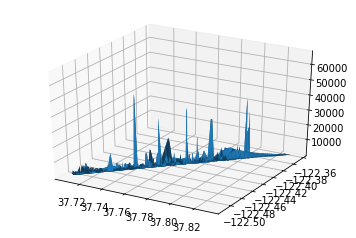

In [18]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xi, yi, zi)
plt.show()

In [10]:
analyze_data = data[data.weekly_price <= 10000]

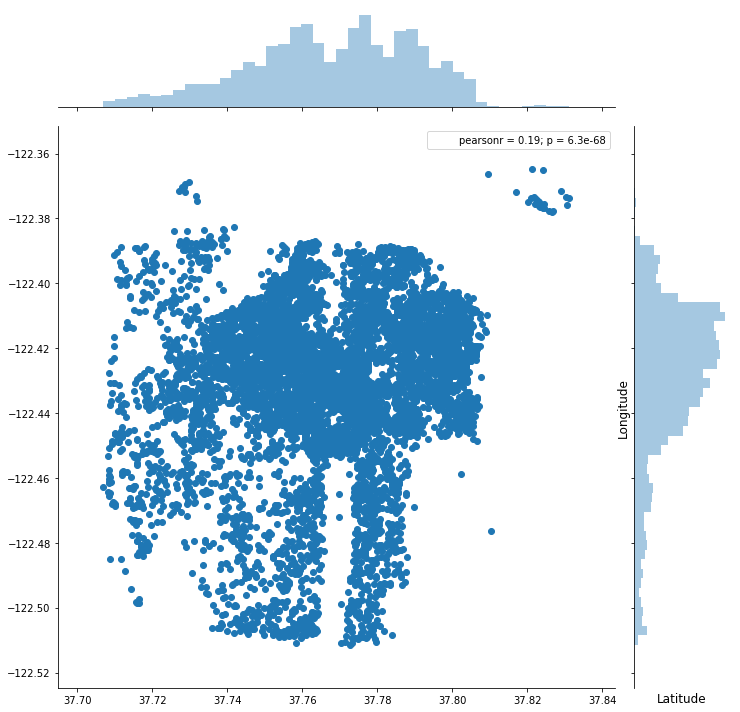

<function seaborn.utils.despine>

In [23]:
plt.figure(figsize=(10,10))
sns.jointplot(x=analyze_data.latitude.values, y=analyze_data.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
sns.despine

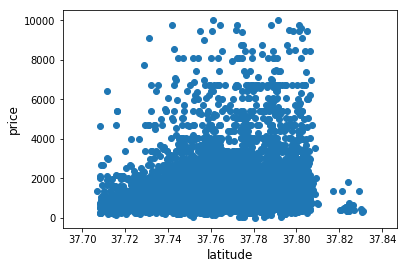

In [14]:
plt.scatter(analyze_data['latitude'], analyze_data['weekly_price'])
plt.xlabel('latitude', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

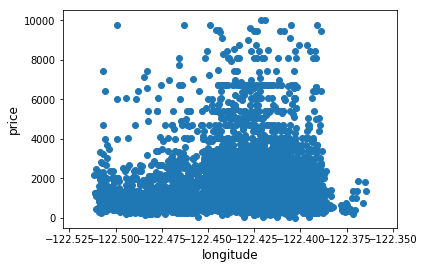

In [15]:
plt.scatter(analyze_data['longitude'], analyze_data['weekly_price'])
plt.xlabel('longitude', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

# Linear Regression

In [140]:
reg = LinearRegression(fit_intercept=True, normalize=True)
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

0.0060246989788662608

# KNN Regressor

In [122]:
reg = KNeighborsRegressor(10)

A score of 0 is if we had just predicted the averages, so this is definitely not a great model

In [123]:
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

-0.033150769897492438

Just looking at the values, to make sure everything has worked out. You can see even from these 10 that the model is not doing a very great job at predicting very high prices.

In [124]:
x_test.head(10)

,latitude,longitude
8325,37.720802,-122.463017
842,37.727048,-122.459462
4943,37.773238,-122.429438
4468,37.796564,-122.413304
5152,37.777702,-122.435590
2915,37.759797,-122.430435
2862,37.762749,-122.403750
3291,37.765173,-122.432329
4134,37.801473,-122.405711
8512,37.756212,-122.415546


In [125]:
y_test.head(10)

,weekly_price
8325,606.528540
842,10749.033573
4943,1010.880900
4468,2021.761801
5152,500.000000
2915,1078.272960
2862,1000.000000
3291,1475.886114
4134,599.789334
8512,673.920600


In [126]:
reg.predict(x_test[:10])

array([[ 1032.59730164],
       [  727.70089652],
       [ 1394.87174366],
       [ 1131.21680399],
       [ 1764.45053077],
       [ 1961.43824569],
       [ 2076.99874708],
       [ 1443.53514471],
       [ 2774.04018503],
       [ 1264.87087463]])

Curious to see that the mean is about the same as the actual dataset, but the standard deviation is much lower. This model doesn't really handle the information very well. This is also pretty apparent with the negative r squared value.

In [127]:
pd.DataFrame(reg.predict(x_test)).describe()

,0
count,1742.000000
mean,1637.366611
std,1023.712785
min,401.568935
25%,1115.304503
50%,1416.401532
75%,1847.105269
max,9009.664354


Saving the information of the model so that it can be used as a function in the actual web app

In [128]:
joblib.dump(reg, 'KNNeighborsRegressor.pkl', protocol=2)

['KNNeighborsRegressor.pkl']

In [129]:
print(type(x_test))

<class 'pandas.core.frame.DataFrame'>


In [130]:
test = joblib.load('KNNeighborsRegressor.pkl') 
test.predict(x_test[:10])

array([[ 1032.59730164],
       [  727.70089652],
       [ 1394.87174366],
       [ 1131.21680399],
       [ 1764.45053077],
       [ 1961.43824569],
       [ 2076.99874708],
       [ 1443.53514471],
       [ 2774.04018503],
       [ 1264.87087463]])

# SVR

In [131]:
svr_reg = SVR()

In [132]:
svr_reg.fit(x_train,y_train)
svr_reg.score(x_test,y_test)

/Users/simran/Desktop/virtual_env/capital-one/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.029058923283725949

In [133]:
pd.DataFrame(svr_reg.predict(x_test)).describe()

,0
count,1742.000000
mean,1051.223342
std,0.563516
min,1049.505447
25%,1050.860471
50%,1051.225237
75%,1051.693124
max,1053.043035


# Gradient Boosting

In [134]:
GBR = GradientBoostingRegressor(n_estimators=2, max_depth=2, learning_rate=.12, random_state=3, max_features=1)
GBR.fit(x_train,y_train)
print(GBR.score(x_test,y_test))
pd.DataFrame(GBR.predict(x_test)).describe()

0.00185978161039


/Users/simran/Desktop/virtual_env/capital-one/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
count,1742.000000
mean,1638.947889
std,51.279072
min,1536.741229
25%,1627.299308
50%,1627.299308
75%,1653.403538
max,1805.732553


In [135]:
param_test = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))};
grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5);
grid_search.fit(x_train,y_train);

NameError: name 'GradientBoostingClassifier' is not defined

# Random Forest

In [ ]:
RFR = RandomForestRegressor(max_depth=3, random_state=3)
RFR.fit(x_train,y_train)
print(RFR.score(x_test,y_test))
pd.DataFrame(RFR.predict(x_test)).describe()

# Calculating the Best Price

Read in all the data, remove unneeded columns

In [ ]:
available_p = pd.read_csv("./data/calendar_available_only.csv")
available_p = available_p[['listing_id', 'price']]
# Replace the string value of the price to a readable float value
available_p['price'] = available_p['price'].str.replace('$', '').str.replace(',', '').astype(float)
listings = pd.read_csv("./data/listings.csv")
listings = listings[['latitude','longitude', 'id']]
# Confirm only non sold houses have prices
all_p = pd.read_csv("./data/calendar.csv").dropna(subset=['price'])
print(all_p.available.unique())

In [ ]:
available_p.head()

Take unique IDs, take the average of the prices with that ID, and find the corresponding locations to the ID

In [ ]:
uniques = available_p.listing_id.unique()
lat = []
long = []
best_price = []
for entry in uniques:
    best_price.append(available_p.loc[available_p['listing_id'] == entry].price.mean())
    found_row = listings.loc[listings['id'] == entry]
    lat.append(found_row.latitude.values[0])
    long.append(found_row.longitude.values[0])

In [ ]:
price_data = pd.DataFrame(
    {'lat': lat,
     'long': long,
     'price': best_price
    })

In [ ]:
price_data.head()

In [ ]:
new_labels = price_data[['price']]
new_features = price_data[['lat', 'long']]
X_train , X_test , Y_train , Y_test = train_test_split(new_features, new_labels , test_size = 0.20,random_state =2)

# KNN Regressor

In [ ]:
reg = KNeighborsRegressor(137)
reg.fit(X_train,Y_train)
print(reg.score(X_test,Y_test))

In [ ]:
X_test.head()

In [ ]:
Y_test.head()

In [ ]:
test = reg.predict(X_test[:5])
print(test)

In [ ]:
joblib.dump(reg, 'KNNeighborsPriceRegressor.pkl', protocol=2)